# Topic Modeling on Complaint Descriptions

In this notebook, we will apply topic modeling to the vectorized complaint descriptions. Topic modeling is an unsupervised technique that helps identify recurring themes or topics within large text datasets. By examining these topics, we can uncover common issues and concerns within the complaints data, aiding in better decision-making.

We will primarily use **Latent Dirichlet Allocation (LDA)**, a probabilistic model that represents each complaint as a mixture of topics and each topic as a mixture of words. 

### Goals of this Notebook
1. **Load Vectorized Data**: Load the Bag-of-Words or TF-IDF matrices created in the previous notebook.
2. **Apply LDA for Topic Extraction**: Use LDA to identify key topics across the complaints.
3. **Interpret Topics**: Display the top words for each topic to understand the main themes in the data.
4. **Evaluate Topics with Coherence Score**: Calculate a coherence score to assess the interpretability and quality of the topics.

This structured approach will allow us to derive meaningful insights from the complaints data, providing a clearer understanding of prevalent issues in New York City's landmark violation reports.


### Import the necessary dependencies

In [13]:
import scipy.sparse
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from scipy.sparse import csr_matrix
from wordcloud import WordCloud

### Loading Vectorized Data

In this section, we load the Bag-of-Words or TF-IDF vectors generated in the previous notebook. These vector representations of the complaint text data will serve as input for our topic modeling analysis.


In [2]:
# Load the Bag-of-Words (BoW) Matrix and the vectorized object
bow_vectors = scipy.sparse.load_npz('../data/processed/bow_vectors.npz')
with open('../data/processed/vectorizer_bow.pkl', 'rb') as f:
    vectorizer_bow = pickle.load(f)

tfidf_vectors = scipy.sparse.load_npz('../data/processed/tfidf_vectors.npz')
with open('../data/processed/vectorizer_tfidf.pkl', 'rb') as f:
    vectorizer_tfidf = pickle.load(f)

# Load the dataframe
complaints_df = pd.read_csv('../data/processed/cleaned_complaints.csv')

### Creation of the corpus and dictionary

The corpus and dictionary is used in both the model creation but also for the coherence score

In [3]:
# Creation of the dicationary and the corpus based on the BoW vectorizers
id2word_bow = {i: w for w, i in vectorizer_bow.vocabulary_.items()}
tokenized_corpus_bow = [[w for w in ({w:i for i, w in id2word_bow.items()}).keys()]]
gensim_dict_bow = Dictionary(tokenized_corpus_bow)
corpus_bow = [[(w, c) for w, c in zip(doc.indices, doc.data)] for doc in csr_matrix(bow_vectors)]

# Creation of the dictionary and the corpus based on the TF-IDF vectorizers
id2word_tfidf = {i:w for w, i in vectorizer_tfidf.vocabulary_.items()}
tokenized_corpus_tfidf = [[w for w in ({w:i for i, w in id2word_tfidf.items()}).keys()]]
gensim_dict_tfidf = Dictionary(tokenized_corpus_tfidf)
corpus_tfidf = [[(w, c) for w, c in zip(doc.indices, doc.data)] for doc in csr_matrix(tfidf_vectors)]

# Creation of the gensim dictionary for the coherence score
gensim_dict_bow = Dictionary(tokenized_corpus_bow)
gensim_dict_tfidf = Dictionary(tokenized_corpus_tfidf)

### Creation of the LDA and LSA models based on both vectorizers
In order to get the best model for the n° of topics, we have to store all of the topics.

In [4]:
model_results = {
    "LDA_BOW": {},
    "LDA_TF-IDF": {},
    "LSA_BOW": {},
    "LSA_TF-IDF": {}
}
for num_topics in range(1, 51):
    # LDA Model
    lda_bow_model = LdaModel(corpus_bow, id2word=gensim_dict_bow, num_topics=num_topics, passes=2)
    lda_tfidf_model = LdaModel(corpus_tfidf, id2word=gensim_dict_tfidf, num_topics=num_topics, passes=2)
    
    # LSA Model
    lsa_bow_model = LsiModel(corpus_bow, id2word=gensim_dict_bow, num_topics=num_topics)
    lsa_tfidf_model = LsiModel(corpus_tfidf, id2word=gensim_dict_tfidf, num_topics=num_topics)

    # Store the models in the dictionary
    model_results['LDA_BOW'][num_topics] = lda_bow_model
    model_results['LDA_TF-IDF'][num_topics] = lda_tfidf_model
    model_results['LSA_BOW'][num_topics] = lsa_bow_model
    model_results['LSA_TF-IDF'][num_topics] = lsa_tfidf_model

### Creation of the function for the Coherence Score
In order to avoid any repeatition and many lines of code, the creation of a function make the process easier.

In [5]:
def calculate_coherence(model, tokenized_corpus, dictionary, coherence_type='c_v'):
    coherence_model = CoherenceModel(model=model, texts=tokenized_corpus, dictionary=dictionary, coherence=coherence_type)
    coherence_score = coherence_model.get_coherence()
    return coherence_score

### Calculation of the Coherence score

In [6]:
# Creation of a dictionary to store the results
coherence_scores = {}

# Looping through the results previously stored
for model_type, model_dict in model_results.items():
    coherence_scores[model_type] = {}
    for num_topics, model in model_dict.items():
        if 'LDA_BOW' or 'LSA_BOW' in model_type:
            corpus = corpus_bow
            dictionary = gensim_dict_bow
            tokenized_corpus = tokenized_corpus_bow
        else:
            corpus = corpus_tfidf
            dictionary = gensim_dict_tfidf
            tokenized_corpus = tokenized_corpus_tfidf
    
        coherence_score = calculate_coherence(model, tokenized_corpus, dictionary)
        coherence_scores[model_type][num_topics] = coherence_score

In [7]:
# Print the highest score for each model
for model_type, scores in coherence_scores.items():
    best_num_topics = max(scores, key=scores.get)
    best_score = scores[best_num_topics]

    print(f"Highest Coherence Score for {model_type}:")
    print(f"Number of Topics: {best_num_topics}")
    print(f"Coherence Score: {best_score}")

Highest Coherence Score for LDA_BOW:
Number of Topics: 1
Coherence Score: 0.9595260136510066
Highest Coherence Score for LDA_TF-IDF:
Number of Topics: 2
Coherence Score: 0.9564441238571066
Highest Coherence Score for LSA_BOW:
Number of Topics: 2
Coherence Score: 0.9167051984314543
Highest Coherence Score for LSA_TF-IDF:
Number of Topics: 10
Coherence Score: 0.7543623359549674


### Creation of a Graph to visualize the results

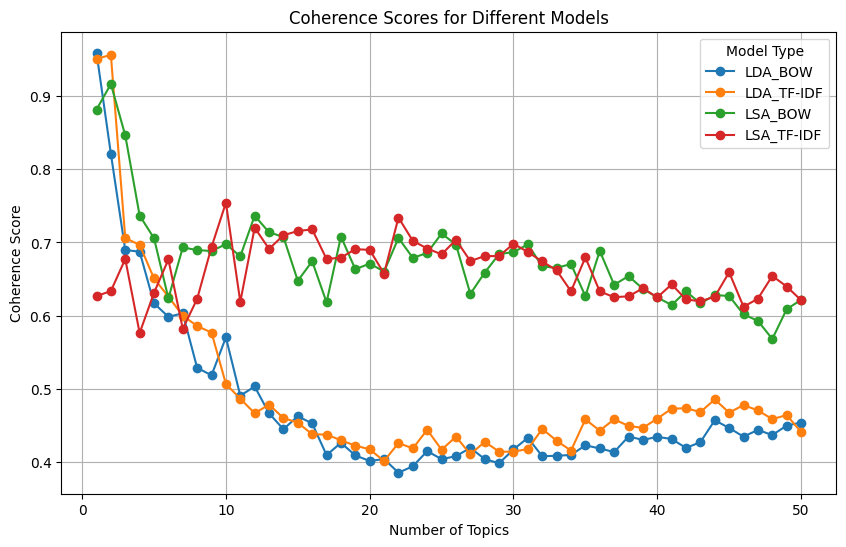

In [8]:
# Initialize a figure for plotting
plt.figure(figsize=(10, 6))

# Loop through the models in coherence_scores and plot their coherence scores
for model_type, scores in coherence_scores.items():
    # Extract the number of topics and the corresponding coherence scores
    num_topics = list(scores.keys())
    coherence_values = list(scores.values())
    
    # Plot the curve for this model
    plt.plot(num_topics, coherence_values, label=model_type, marker='o')

# Add labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Models')
plt.legend(title='Model Type')

# Display grid for better visualization
plt.grid(True)

# Show the plot
plt.show()

### Creation of the Wordcloud based on the Topics Coherence Score

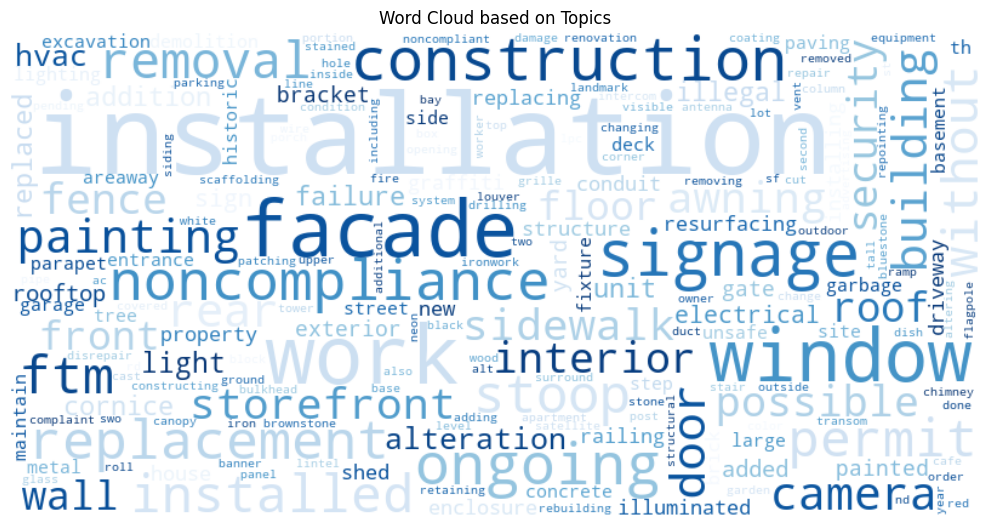

In [14]:
# Initialize a dictionary to store the word frequencies for the word cloud
wordcloud_data = {}
# Looping through the models and extracting the top words
for model_type, model_dict in model_results.items():
    for num_topics, model in model_dict.items():
        # Extract the topics (word-weight pairs) from the model
        topics = model.print_topics(num_topics=num_topics)

        # Loop through each topic and extract the word-weight pairs
        for topic in topics:
            topic_words_weights = topic[1].split(" + ")

            # Process each word-weight pair
            for word_weight in topic_words_weights:
                weight, word = word_weight.split('*')
                weight = float(weight)  # Convert weight to a float
                word = word.strip('"')  # Clean up the word string

                # Add the word and its weight to the dictionary (accumulating if the word already exists)
                if word in wordcloud_data:
                    wordcloud_data[word] += weight  # Add weight to existing word
                else:
                    wordcloud_data[word] = weight  # Initialize word with its weight

# Create the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues',
    contour_color='black',
).generate_from_frequencies(wordcloud_data)

# Display the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud based on Topics')
plt.tight_layout()
plt.show()